# **E17. Session based Context-Aware RecSys**

## **INDEX**

00. 필요한 함수 가져오기

01. 데이터 읽어오기

02. EDA

03. Train, Test, Val set 생성

04. Modeling

05. Train & Test

06. 회고

> **REF** : [hjkornn-phys github](https://github.com/hjkornn-phys/Aiffel-Exploration-projects/blob/master/Exploration_12/EX12_Session_based_Recommendation.ipynb)

---

## **00. 필요한 함수 가져오기**

In [2]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import datetime as dt
from pathlib import Path

from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


print("Done!")

Done!


---

## **01. 데이터 읽어오기**

In [4]:
data_path = Path('/content/mydrive/MyDrive/AIFFEL/E17/data')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0,1,2,3],
                       dtype={0:np.int32, 1:np.int32, 2:np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)

# data를 id와 시간 순서로 정렬
data.sort_values(['UserId', 'Time'], inplace=True)

data

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


---

## **02. EDA**

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
action_num = data.groupby('UserId').size()
action_num

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
action_num.max()

2314

In [8]:
action_num.min()

20

In [9]:
action_num.median()

96.0

In [10]:
action_num.mean()

165.5975165562914

In [11]:
action_num.quantile(0.999)

1343.181000000005

유저별로 생성한 타임스탬프 수의 차이가 큽니다.

하지만 대부분은 1343.18개 이하의 액션을 취했습니다.

1액션 != 1세션인 점을 주의합니다.

In [12]:
strange = action_num[action_num >= 1344]
strange

UserId
889     1518
1181    1521
1680    1850
1941    1595
3618    1344
4169    2314
4277    1743
dtype: int64

하위 0.01%의 이상치를 살펴보겠습니다.

In [13]:
data[data['UserId'] == strange.index[0]]

,UserId,ItemId,Rating,Time
137631,889,1266,3,975247862
137864,889,2430,3,975247862
137889,889,1643,3,975247862
138039,889,3461,3,975247862
138316,889,1193,1,975247862
...,...,...,...,...
138285,889,1322,1,975364486
138292,889,1328,1,975364486
139033,889,2974,2,975364486
137720,889,3047,5,975364518


여러 데이터를 한번에 입력하는 것처럼 보입니다.

데이터 비중이 낮으니 일단 제거하지 않고 사용합니다.

이제 유저별 데이터를 세션으로 나눠야 합니다.

일정 시간 이상 클릭하지 않으면 다음 세션으로 넘어가는 것으로 생각하겠습니다.

---

### **02-1. SessionId 생성**

In [29]:
sessiondata = data.copy()

sessiondata['timegap'] = sessiondata['Time'].diff().fillna(0)
sessiondata['user_diff'] = sessiondata['UserId'].diff().fillna(0)

session_id = 1
def make_sessions(x, max_diff):
    global session_id
    if x['timegap'] > max_diff or x['user_diff'] == 1:
        session_id += 1
    return session_id

print("Done!")

Done!


In [30]:
sessiondata

,UserId,ItemId,Rating,Time,timegap,user_diff
31,1,3186,4,978300019,0.0,0.0
22,1,1270,5,978300055,36.0,0.0
27,1,1721,4,978300055,0.0,0.0
37,1,1022,5,978300055,0.0,0.0
24,1,2340,3,978300103,48.0,0.0
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,31.0,0.0
999988,6040,1921,4,997454464,35.0,0.0
1000172,6040,1784,3,997454464,0.0,0.0
1000167,6040,161,3,997454486,22.0,0.0


timegap의 전체 분포를 확인해봅니다.

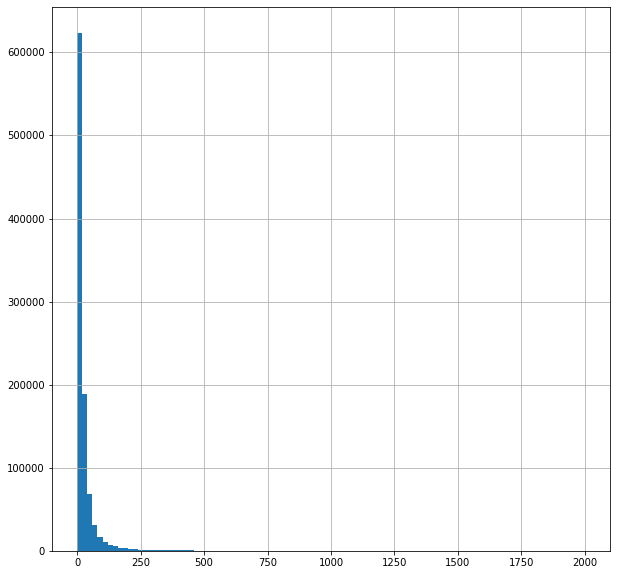

In [155]:
plt.figure(figsize=(10, 10))
user_sessions = sessiondata[sessiondata['user_diff']!=1]['timegap']
user_sessions[user_sessions<2000].hist(bins=100)


약 250초 정도 간격으로 세션id를 생성하겠습니다.

In [42]:
session_id = 1
def make_session_id(x):
    global session_id
    if x['timegap'] > 250 or x['user_diff'] == 1:
        session_id += 1
    return session_id

In [43]:
sessiondata['SessionId'] = sessiondata.apply(make_session_id, axis=1)

In [44]:
sessiondata

,UserId,ItemId,Rating,Time,timegap,user_diff,SessionId
31,1,3186,4,978300019,0.0,0.0,1
22,1,1270,5,978300055,36.0,0.0,1
27,1,1721,4,978300055,0.0,0.0,1
37,1,1022,5,978300055,0.0,0.0,1
24,1,2340,3,978300103,48.0,0.0,1
...,...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,31.0,0.0,37502
999988,6040,1921,4,997454464,35.0,0.0,37502
1000172,6040,1784,3,997454464,0.0,0.0,37502
1000167,6040,161,3,997454486,22.0,0.0,37502


세션별 길이를 확인하고 활동 내역이 너무 적은 세션은 제거합니다.

In [46]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data


print("Done!")

Done!


In [47]:
clean_data = cleanse_recursive(sessiondata, shortest=3, least_click=5)
clean_data

,UserId,ItemId,Rating,Time,timegap,user_diff,SessionId
31,1,3186,4,978300019,0.0,0.0,1
22,1,1270,5,978300055,36.0,0.0,1
27,1,1721,4,978300055,0.0,0.0,1
37,1,1022,5,978300055,0.0,0.0,1
24,1,2340,3,978300103,48.0,0.0,1
...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,31.0,0.0,37502
1000019,6040,2917,4,997454429,31.0,0.0,37502
999988,6040,1921,4,997454464,35.0,0.0,37502
1000172,6040,1784,3,997454464,0.0,0.0,37502


1,000,209개에서 980,781개의 데이터로 줄어들었습니다.

이번에는 오래된 데이터를 제거합니다.

Time 항목에는 UTC time 가 포함되어,

1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

변환해줍니다.

In [48]:
def convert_datetime(unixtime):
    """Convert unixtime to datetime"""
    date = dt.datetime.fromtimestamp(unixtime).strftime('%Y-%m-%d %H:%M:%S')
    date = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    return date # format : timestamp

print("Done!")

Done!


In [49]:
clean_data['Time'] = clean_data.Time.apply(convert_datetime)

In [50]:
oldest, latest = clean_data['Time'].min(), clean_data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


약 3년간의 데이터입니다.

세션 분포를 확인해보겠습니다.

In [51]:
session_length = clean_data.groupby('SessionId').size()

In [52]:
session_length

SessionId
1          7
2          5
3         28
4         13
5        129
        ... 
37496     19
37497     15
37499      6
37500     14
37502     21
Length: 22687, dtype: int64

In [53]:
session_length.min()

3

In [54]:
session_length.max()

1192

In [55]:
session_length.median()

17.0

In [56]:
session_length.mean()

43.230969277559836

In [57]:
session_length.quantile(0.999)

667.6280000000042

길이가 긴 세션을 살펴보겠습니다.

In [64]:
long_session = session_length[session_length>668].index[0]
clean_data[clean_data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,timegap,user_diff,SessionId
30065,202,64,3,2000-12-16 02:38:26,-33956279.0,1.0,1559
29542,202,1196,5,2000-12-16 02:38:27,1.0,0.0,1559
29800,202,209,3,2000-12-16 02:38:27,0.0,0.0,1559
29580,202,1359,2,2000-12-16 02:38:57,30.0,0.0,1559
29739,202,3255,4,2000-12-16 02:38:57,0.0,0.0,1559
...,...,...,...,...,...,...,...
29971,202,1022,3,2000-12-16 04:40:18,0.0,0.0,1559
29978,202,1029,3,2000-12-16 04:40:18,0.0,0.0,1559
29553,202,2141,3,2000-12-16 04:40:35,17.0,0.0,1559
29591,202,2092,2,2000-12-16 04:41:12,37.0,0.0,1559


In [65]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

3      0.096223
4      0.160444
5      0.227663
6      0.278353
7      0.318332
         ...   
646    0.998766
651    0.998854
656    0.998898
662    0.998942
667    0.998986
Length: 469, dtype: float64

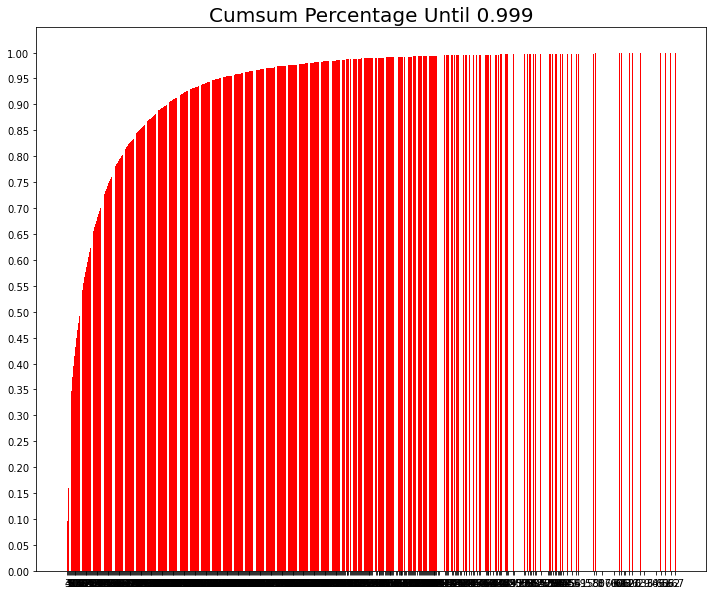

In [66]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

누적합 95%까지만 사용합니다.

In [67]:
cumsum_95 = length_percent_cumsum_999[length_percent_cumsum_999<0.95]
cumsum_95

3      0.096223
4      0.160444
5      0.227663
6      0.278353
7      0.318332
         ...   
164    0.947547
165    0.948208
166    0.948649
167    0.949398
168    0.949839
Length: 166, dtype: float64

액션 횟수 최대 168까지의 데이터를 잘라냅니다.

In [68]:
effective_sessionid = session_length.apply(lambda g: 3<=g<=168)
print(effective_sessionid)
print(effective_sessionid.mean())

SessionId
1        True
2        True
3        True
4        True
5        True
         ... 
37496    True
37497    True
37499    True
37500    True
37502    True
Length: 22687, dtype: bool
0.9498391149116234


In [69]:
sessionids = effective_sessionid[effective_sessionid==True]
session_list = sessionids.index.to_list()
len(session_list)

21549

In [74]:
clean_data = clean_data[['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']]
clean_data = clean_data[clean_data['SessionId'].isin(session_list)]
clean_data.reset_index(drop=True, inplace=True)
clean_data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,1
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
658952,6040,232,5,2001-08-10 14:39:58,37502
658953,6040,2917,4,2001-08-10 14:40:29,37502
658954,6040,1921,4,2001-08-10 14:41:04,37502
658955,6040,1784,3,2001-08-10 14:41:04,37502


clean_data는 3개 이상, 168개 이하의 액션을 가진 세션들로 이루어진 데이터가 되었습니다.


---

## **03. Train, Val, Test Set 생성**

In [96]:
start_timestamp = latest - dt.timedelta(30*20)     # 최종 날짜로부터 17개월 이전 날짜를 구한다.  
datasets = clean_data[clean_data['Time'] > start_timestamp]   # 방금 구한 날짜 이후의 데이터만 모은다. 

print("Done!")

Done!


In [97]:
datasets

,UserId,ItemId,Rating,Time,SessionId
1732,20,1694,3,2001-12-29 23:37:51,71
1733,20,1468,3,2001-12-29 23:37:51,71
1734,20,3717,2,2001-12-29 23:37:51,71
1735,20,2858,4,2001-12-29 23:37:51,71
1736,20,2641,4,2001-12-29 23:38:35,71
...,...,...,...,...,...
658952,6040,232,5,2001-08-10 14:39:58,37502
658953,6040,2917,4,2001-08-10 14:40:29,37502
658954,6040,1921,4,2001-08-10 14:41:04,37502
658955,6040,1784,3,2001-08-10 14:41:04,37502


train set에 15개월, val set에서 3개월, test set에 2개월씩 배분합니다.

In [98]:
# 평점 3 이상만 남김
datasets = datasets[datasets['Rating']>=3]

print("Done!")

Done!


In [99]:
# least_click의 경우 rating의 최소 개수를 의미합니다.
cleansed_datasets = cleanse_recursive(datasets, shortest=3, least_click=20)
cleansed_datasets

,UserId,ItemId,Rating,Time,SessionId
1735,20,2858,4,2001-12-29 23:37:51,71
1737,20,1375,3,2001-12-29 23:38:35,71
1738,20,3753,5,2001-12-29 23:38:36,71
1739,20,3527,4,2001-12-29 23:39:41,71
1740,20,1527,5,2001-12-29 23:39:41,71
...,...,...,...,...,...
658950,6040,457,4,2001-08-10 14:39:09,37502
658951,6040,3671,4,2001-08-10 14:39:27,37502
658954,6040,1921,4,2001-08-10 14:41:04,37502
658955,6040,1784,3,2001-08-10 14:41:04,37502


In [100]:
cleansed_datasets.reset_index(drop=True, inplace=True)
cleansed_datasets['Session_change'] = cleansed_datasets['SessionId'].diff().fillna(0)

new_session_id = 0
def reset_sessions(x):
    global new_session_id
    if x['Session_change']:
        new_session_id += 1
    return new_session_id
         
cleansed_datasets['SessionId'] = cleansed_datasets.apply(reset_sessions, axis=1)
cleansed_datasets = cleansed_datasets[['ItemId', 'Time', 'SessionId']]
cleansed_datasets

,ItemId,Time,SessionId
0,2858,2001-12-29 23:37:51,0
1,1375,2001-12-29 23:38:35,0
2,3753,2001-12-29 23:38:36,0
3,3527,2001-12-29 23:39:41,0
4,1527,2001-12-29 23:39:41,0
...,...,...,...
11989,457,2001-08-10 14:39:09,1239
11990,3671,2001-08-10 14:39:27,1239
11991,1921,2001-08-10 14:41:04,1239
11992,1784,2001-08-10 14:41:04,1239


In [101]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

print("Done!")

Done!


In [102]:
tr, test = split_by_date(cleansed_datasets, n_days=60)
tr, val = split_by_date(tr, n_days=90)

print("Done!")

Done!


In [103]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')


print("Done!")

Done!


In [104]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 10078
	 Sessions: 1046
	 Items: 368
	 First Time : 2001-07-08 19:44:06
	 Last Time : 2002-09-29 23:16:00

* valid Set Stats Info
	 Events: 955
	 Sessions: 105
	 Items: 333
	 First Time : 2002-10-05 02:21:48
	 Last Time : 2002-12-29 04:39:37

* test Set Stats Info
	 Events: 961
	 Sessions: 89
	 Items: 340
	 First Time : 2002-12-29 20:57:38
	 Last Time : 2003-02-27 18:17:38



In [125]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

print("Done!")

Done!


In [126]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

print("Done!")

Done!


In [127]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

print("Done!")

Done!


In [128]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,ItemId,Time,SessionId,item_idx
0,2858,2001-12-29 23:37:51,0,0
1,1375,2001-12-29 23:38:35,0,1
2,3753,2001-12-29 23:38:36,0,2
3,3527,2001-12-29 23:39:41,0,3
4,1527,2001-12-29 23:39:41,0,4
5,1240,2001-12-29 23:39:41,0,5
6,1371,2001-12-29 23:40:27,0,6
7,1387,2002-03-12 03:46:59,1,7
8,1201,2002-03-12 03:46:59,1,8
9,1291,2002-03-12 03:47:16,1,9


In [129]:
tr_dataset.click_offsets

array([    0,     7,    12, ..., 10053, 10065, 10078], dtype=int32)

In [130]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 1043, 1044, 1045])

In [131]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished


print("Done!")

Done!


---

## **04. Modeling**

In [132]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)


print("Done!")

Done!


In [133]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model


print("Done!")

Done!


In [145]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1,\
            lr=0.001, epochs=100, k=20)

print("Done!")

Done!


---

## **05. Train & Test**

In [146]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        yield {"val_recall": val_recall}
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


print("Done!")

Done!


In [149]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

print("Done!")

Done!


In [150]:
model = create_model(args)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(32, 1, 368)]            0         
                                                                 
 GRU (GRU)                   [(32, 50),                63000     
                              (32, 50)]                          
                                                                 
 dropout_7 (Dropout)         (32, 50)                  0         
                                                                 
 dense_7 (Dense)             (32, 368)                 18768     
                                                                 
Total params: 81,768
Trainable params: 81,768
Non-trainable params: 0
_________________________________________________________________


In [151]:
train_model(model, args)

<generator object train_model at 0x7f008d50e350>

In [152]:
test_model(model, args, test)

Evaluation:  52%|█████▏    | 14/27 [00:04<00:04,  2.85it/s]

	 - Recall@20: 0.075893
	 - MRR@20: 0.014194



### **05-1. 개선**

In [153]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1,\
            lr=0.001, epochs=12, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(32, 1, 368)]            0         
                                                                 
 GRU (GRU)                   [(32, 50),                63000     
                              (32, 50)]                          
                                                                 
 dropout_8 (Dropout)         (32, 50)                  0         
                                                                 
 dense_8 (Dense)             (32, 368)                 18768     
                                                                 
Total params: 81,768
Trainable params: 81,768
Non-trainable params: 0
_________________________________________________________________


<generator object train_model at 0x7f009e1326d0>

In [154]:
test_model(model, args, test)

Evaluation:  52%|█████▏    | 14/27 [00:05<00:05,  2.44it/s]

	 - Recall@20: 0.042411
	 - MRR@20: 0.007366



## **06. 회고**

Val | Score | Val | Score
:--|:--|:--|:--
1차 Recall | 0.075893 | 최종 Recall | 0.042411
1차 MRR | 0.014194 | 최종 MRR | 0.007366


마지막 EX노드라 그런지 많이 어려웠습니다.

추후 다른 방식으로 다시 시도해볼 생각입니다.